In [1]:
batch_size = 64
ncomps = 1500
crop_size = 180

In [2]:
import logging
import os
import sys
import random
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity, NormalizeIntensity, ToTensor
import pickle
import argparse
from monai.data.utils import pad_list_data_collate
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

from SFCN import SFCNModel
import torchvision.transforms.functional as F

2024-05-15 13:46:32.652447: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 13:46:32.653763: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 13:46:32.679262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 13:46:33.177728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/volatope/Software/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: tor

In [98]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/'no_bias'/'train'

# test_csv_path = macaw_path/'data'/'ukbb'/'test_hc.csv'
# test_img_path = macaw_path/'data'/'ukbb'/'axial'/'test_hc'
# 
kpca_path = macaw_path/'splits'/f'train_hc_kpca_{ncomps}.pkl'
# 
train_path = macaw_path/'splits'/f'train_hc_data_KPCA_{ncomps}.pkl'
# test_path = macaw_path/'data'/'ukbb'/'axial'/f'test_hc_data_KPCA_{ncomps}.pkl'

In [4]:
home_dir = './'
exp_name = 'no_bias'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(os.path.join(home_dir, "splits/train.csv"))
df_val = pd.read_csv(os.path.join(home_dir, "splits/val.csv"))

train_fpaths = [os.path.join(working_dir, "train", filename.replace(".nii.gz", ".tiff")) for filename in df_train['filename']]
train_class_label = df_train['class_label']

val_fpaths = [os.path.join(working_dir, "val", filename.replace(".nii.gz", ".tiff")) for filename in df_val['filename']]
val_class_label = df_val['class_label']

In [72]:
def recons(age,bmi,latents, latent_offset=0):
    age+=min_age
    
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    imgs = kpca.inverse_transform(latent_enc)
    return age,bmi,imgs

def show(data,n=4):
    fig, axs = plt.subplots(ncols=n, squeeze=False, figsize=(10,10))
    for i in range(n):
        img = F.to_pil_image(data[0][i].detach())
        axs[0, i].imshow(np.asarray(img), cmap='cividis')        
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=make_label(data,i))
        
def make_label(d,i):
    s = ['Female', 'Male']
    return f"Sex: {s[int(d[0][i])]},  Age: {np.round(d[1][i])},\n BMI: {np.round(d[2][i],2)}"

In [73]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [74]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [75]:
from datasets import EmmaDataset
from monai.data import pad_list_data_collate
from torchvision.transforms import CenterCrop

# Define transforms
transforms = Compose([ToTensor(),CenterCrop(crop_size), NormalizeIntensity()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
# train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_ds = EmmaDataset(train_csv_path, train_img_path, transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

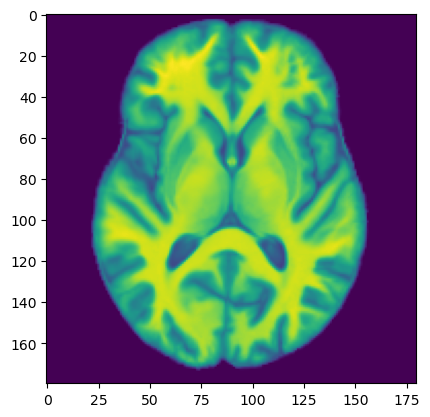

In [77]:
plt.imshow(next(iter(train_loader))[2][1])

In [93]:
imgs = np.concatenate([d[2].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

In [94]:
imgs

array([[-1.0279601, -1.0279601, -1.0279601, ..., -1.0279601, -1.0279601,
        -1.0279601],
       [-1.0290431, -1.0290431, -1.0290431, ..., -1.0290431, -1.0290431,
        -1.0290431],
       [-1.0380565, -1.0380565, -1.0380565, ..., -1.0380565, -1.0380565,
        -1.0380565],
       ...,
       [-1.032913 , -1.032913 , -1.032913 , ..., -1.032913 , -1.032913 ,
        -1.032913 ],
       [-1.0351275, -1.0351275, -1.0351275, ..., -1.0351275, -1.0351275,
        -1.0351275],
       [-1.0374941, -1.0374941, -1.0374941, ..., -1.0374941, -1.0374941,
        -1.0374941]], dtype=float32)

In [95]:
import pickle
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=ncomps, kernel="poly", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
kpca.fit(imgs)

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:410: LinAlgWarning: Ill-conditioned matrix (rcond=3.2921e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


KernelPCA(alpha=0.005, fit_inverse_transform=True, gamma=0.001, kernel='poly',
          n_components=1500)

In [106]:
kpca_path

PosixPath('/home/volatope/PycharmProjects/CounterBias/splits/train_hc_kpca_1500.pkl')

## Dimensionality reduction

In [105]:
import pickle
from sklearn.decomposition import KernelPCA

if os.path.exists(kpca_path):
    with open(kpca_path, 'rb') as f:
        kpca = pickle.load(f)
else:
    kpca = KernelPCA(n_components=ncomps, kernel="poly", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
    kpca.fit(imgs)
    
    with open(kpca_path, 'wb') as f:
        pickle.dump(kpca, f)

In [96]:
disease = np.concatenate([d[0].numpy() for d in train_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in train_loader],axis=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

age = np.round(age)
min_age = np.min(age)
age-=min_age

In [97]:
encoded_data = kpca.transform(imgs)

In [102]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease:':disease,'bias:':bias, 'kpca':kpca,'encoded_data':encoded_data}, f)

In [ ]:
test_dataset = UKBBT1Dataset(test_csv_path, test_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
show(next(iter(test_loader)))

In [ ]:
test_imgs = np.concatenate([d[3].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

In [ ]:
sample_imgs = test_imgs[:5,:]
t = kpca.transform(sample_imgs)
X_recon = kpca.inverse_transform(t)

In [ ]:
import utils.visualize as vis

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in diff], clim=(-1,1), cols=5, cmap='seismic')
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in rr], clim=(0,1), cols=5)

In [ ]:
sex = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
age = np.concatenate([d[1].numpy() for d in test_loader],axis=0)
bmi = np.concatenate([d[2].numpy() for d in test_loader],axis=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

age = np.round(age)
age-=min_age

encoded_data = kpca.transform(test_imgs)

In [ ]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'sex':sex,'age':age, 'bmi':bmi, 'kpca':kpca,'encoded_data':encoded_data, 'min_age':min_age}, f)